# Test Best Models

Test notebook to generate the statistics of the different models found with AMS. First load the required libraries

In [1]:
import datetime
import logging
import sys
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.callbacks import LearningRateScheduler
from keras.optimizers import Adam
import keras.backend as K
from keras.models import model_from_json

from sklearn.model_selection import KFold
from scipy import stats

#sys.path.append('/Users/davidlaredorazo/Documents/University_of_California/Research/Projects')
sys.path.append('/media/controlslab/DATA/Projects')

import ann_framework.aux_functions as aux_functions

import automatic_model_selection
from automatic_model_selection import Configuration
from ann_encoding_rules import Layers
import fetch_to_keras
#from CMAPSAuxFunctions import TrainValTensorBoard

#Tunable model
from ann_framework.tunable_model.tunable_model import SequenceTunableModelRegression, SequenceTunableModelClassification

#Data handlers
from ann_framework.data_handlers.data_handler_CMAPSS import CMAPSSDataHandler
from ann_framework.data_handlers.data_handler_MNIST import MNISTDataHandler
from ann_framework.data_handlers.data_handler_CIFAR10 import CIFAR10DataHandler

Using TensorFlow backend.


### Given a model, get the compiled model

In [2]:
def get_compiled_model(model, problem_type, optimizer_params=[]):
    """Obtain a keras compiled model"""
    
    #Shared parameters for the models
    optimizer = Adam(lr=0.001, beta_1=0.5)
    
    if problem_type == 1:
        lossFunction = "mean_squared_error"
        metrics = ["mse"]
    elif problem_type == 2:
        lossFunction = "categorical_crossentropy"
        metrics = ["accuracy"]
    else:
        print("Problem type not defined")
        model = None
        return
    
    #Create and compile the models
    model.compile(optimizer = optimizer, loss = lossFunction, metrics = metrics)
    
    return model


def create_tunable_model(model_genotype, problem_type, input_shape, data_handler, model_number):
    
    K.clear_session()
    
    model = fetch_to_keras.decode_genotype(model_genotype, problem_type, input_shape, 1)
    
    model = get_compiled_model(model, problem_type, optimizer_params=[])
    
    if problem_type == 1:
        tModel = SequenceTunableModelRegression('ModelReg_SN_'+str(model_number), model, lib_type='keras', data_handler=data_handler)
    else:
        tModel = SequenceTunableModelClassification('ModelClass_SN_'+str(model_number), model, lib_type='keras', data_handler=data_handler)
        
    return tModel

### Load cmaps data handler

In [3]:
def cmapss_dhandler(data_scaler=None):

    #Selected as per CNN paper
    features = ['T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 'Nf', 'Nc', 'epr', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 
    'farB', 'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32']
    selected_indices = np.array([2, 3, 4, 7, 8, 9, 11, 12, 13, 14, 15, 17, 20, 21])
    selected_features = list(features[i] for i in selected_indices-1)
    data_folder = '../CMAPSSData'

    window_size = 24
    window_stride = 1
    max_rul = 129

    dhandler_cmapss = CMAPSSDataHandler(data_folder, 1, selected_features,
                                       max_rul, window_size, window_stride, data_scaler=data_scaler)

    input_shape = (len(selected_features)*window_size, )

    return dhandler_cmapss

### Load models and evaluate model

In [4]:
def load_model(model_file, weights_file="", problem_type=1):
    
    p_type = ""
    
    # load json and create model
    json_file = open(model_file, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    print("Loaded model from disk") 
        
    #Load weights if specified
    if weights_file != "":
        # load weights into new model
        loaded_model.load_weights(weights_file)
        print("Loaded weights from disk") 
    else:
        print("Model needs training")
        
    optimizer = Adam(lr=0.001, beta_1=0.5)
    
    if problem_type == 1:
        p_type = "regression"
        lossFunction = "mean_squared_error"
        metrics = ["mse"]
    elif problem_type == 2:
        p_type = "classification"
        lossFunction = "categorical_crossentropy"
        metrics = ["accuracy"]
    else:
        print("Problem type not defined")
        model = None
        return
    
    #Create and compile the models
    loaded_model.compile(optimizer = optimizer, loss = lossFunction, metrics = metrics)
    print("Created model for " + p_type + " with loss function " + lossFunction)

    return loaded_model
        
        

### Load each of the models and test them

In [5]:
best_model_folder = 'best_models'
"""
test_sets = {'cifar10':(CIFAR10DataHandler, None, 2), 
             'cmapss':(cmaps_dhandler, MinMaxScaler(feature_range=(-1, 1)), 1), 
             'mnist':(MNISTDataHandler, None, 2)}
"""

test_sets = {'cmapss':(cmapss_dhandler, MinMaxScaler(feature_range=(-1, 1)), 1)}
#alpha_folders = ['alpha0.6', 'alpha0.8', 'alpha1']
#alpha_folders = ['alpha0.5']
alpha_values = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
#alpha_values = [0.2]

In [6]:
results = {}

k = 5  #For 10-fold cross validation

for dataset in test_sets.keys():
    for alphaValue in alpha_values:
        
        model_file_name = 'yulin/alpha{}/bestModel_global.json'.format(alphaValue)
        weights_file_name = 'yulin/alpha{}/bestModel_global.h5'.format(alphaValue)
        trainable_count = 0
        
        print("Testing for "+model_file_name)
        
        results_key = dataset + "_" +  str(alphaValue)
        
        evaluations_cv = np.zeros(k)
        evaluations_test = np.zeros(k)
        
        model_location = best_model_folder + '/' + dataset + '/' + model_file_name
        
        if weights_file_name != "":
            weights_location = best_model_folder + '/' + dataset + '/' + weights_file_name
        
        dhandler, data_scaler, problem_type = test_sets[dataset]

        #model = load_model(model_location, weights_location, problem_type)   
        
        data_handler = dhandler(data_scaler=data_scaler)
        data_handler.load_data(verbose = 1, unroll=True)
        data_handler.print_data()
        
        folds = list(KFold(n_splits=k, shuffle=True).split(data_handler.X_train))
        
        print('Validation on model:' + model_location)
        
        for j, (train_idx, val_idx) in enumerate(folds):

            print('\nExperiment on Fold ', j)
            
            K.clear_session()  #Clear the previous tensorflow graph 

            X_train_cv = data_handler.X_train[train_idx]
            y_train_cv = data_handler.y_train[train_idx]
            X_valid_cv = data_handler.X_train[val_idx]
            y_valid_cv = data_handler.y_train[val_idx]

            model = load_model(model_location, "", problem_type)
            model.summary()
            trainable_count = int(np.sum([K.count_params(p) for p in set(model.trainable_weights)]))

            model.fit(X_train_cv, y_train_cv, batch_size=512, epochs=100, verbose=1)

            evaluation_cv = model.evaluate(X_valid_cv, y_valid_cv)
            evaluation_test = model.evaluate(data_handler.X_test, data_handler.y_test)

            evaluations_cv[j] = evaluation_cv[1]
            evaluations_test[j] = evaluation_test[1]
            
        results[results_key] = (evaluations_cv, evaluations_test, trainable_count)
        

Testing for yulin/alpha0.2/bestModel_global.json
Loading data for dataset 1 with window_size of 24, stride of 1 and maxRUL of 129. Cros-Validation ratio 0
Loading data from file and computing dataframes


/home/controlslab/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Printing shapes

Training data (X, y)
(18331, 336)
(18331, 1)
Testing data (X, y)
(100, 336)
(100, 1)
Printing first 5 elements

Training data (X, y)
[[-0.63253012 -0.18639634 -0.38048616 ... -0.33333333  0.33333333
   0.31289699]
 [-0.43373494 -0.09396119 -0.29473329 ... -0.16666667  0.25581395
   0.47638774]
 [-0.31325301 -0.26095487 -0.25894666 ...  0.          0.11627907
   0.43800055]
 [-0.31325301 -0.48768258 -0.33760972 ... -0.16666667  0.31782946
   0.52720243]
 [-0.30120482 -0.48506649 -0.19074949 ... -0.66666667  0.34883721
   0.07677437]]
[[129.]
 [129.]
 [129.]
 [129.]
 [129.]]
Testing data (X, y)
[[-0.19879518 -0.5705254  -0.37069548 ... -0.16666667  0.03875969
   0.27312897]
 [-0.21686747 -0.30237628 -0.12086428 ... -0.5         0.03875969
   0.01518917]
 [-0.04216867 -0.1942446  -0.0209318  ...  0.16666667  0.2248062
   0.04888152]
 [-0.22891566 -0.01722259 -0.13673194 ...  0.16666667 -0.31782946
   0.004971  ]
 [-0.11445783 -0.11968607  0.03511141 ...  0.         -0.054

14665/14665 [==============================] - 0s 3us/step - loss: 241.4747 - mean_squared_error: 241.4747
Epoch 13/100
14665/14665 [==============================] - 0s 3us/step - loss: 233.5817 - mean_squared_error: 233.5817
Epoch 14/100
14665/14665 [==============================] - 0s 3us/step - loss: 234.7131 - mean_squared_error: 234.7131
Epoch 15/100
14665/14665 [==============================] - 0s 3us/step - loss: 237.8782 - mean_squared_error: 237.8782
Epoch 16/100
14665/14665 [==============================] - 0s 3us/step - loss: 233.9340 - mean_squared_error: 233.9340
Epoch 17/100
14665/14665 [==============================] - 0s 3us/step - loss: 228.7368 - mean_squared_error: 228.7368
Epoch 18/100
14665/14665 [==============================] - 0s 3us/step - loss: 230.7056 - mean_squared_error: 230.7056
Epoch 19/100
14665/14665 [==============================] - 0s 3us/step - loss: 240.2914 - mean_squared_error: 240.2914
Epoch 20/100
14665/14665 [===========================

14665/14665 [==============================] - 0s 3us/step - loss: 196.2427 - mean_squared_error: 196.2427
Epoch 41/100
14665/14665 [==============================] - 0s 3us/step - loss: 189.3873 - mean_squared_error: 189.3873
Epoch 42/100
14665/14665 [==============================] - 0s 3us/step - loss: 209.9176 - mean_squared_error: 209.9176
Epoch 43/100
14665/14665 [==============================] - 0s 3us/step - loss: 190.0057 - mean_squared_error: 190.0057
Epoch 44/100
14665/14665 [==============================] - 0s 3us/step - loss: 187.4821 - mean_squared_error: 187.4821
Epoch 45/100
14665/14665 [==============================] - 0s 3us/step - loss: 196.0782 - mean_squared_error: 196.0782
Epoch 46/100
14665/14665 [==============================] - 0s 3us/step - loss: 192.2194 - mean_squared_error: 192.2194
Epoch 47/100
14665/14665 [==============================] - 0s 3us/step - loss: 190.3305 - mean_squared_error: 190.3305
Epoch 48/100
14665/14665 [===========================

Epoch 1/100
14665/14665 [==============================] - 0s 15us/step - loss: 2882.3414 - mean_squared_error: 2882.3414
Epoch 2/100
14665/14665 [==============================] - 0s 3us/step - loss: 459.1280 - mean_squared_error: 459.1280
Epoch 3/100
14665/14665 [==============================] - 0s 3us/step - loss: 353.2621 - mean_squared_error: 353.2621
Epoch 4/100
14665/14665 [==============================] - 0s 3us/step - loss: 298.0061 - mean_squared_error: 298.0061
Epoch 5/100
14665/14665 [==============================] - 0s 3us/step - loss: 276.9815 - mean_squared_error: 276.9815
Epoch 6/100
14665/14665 [==============================] - 0s 3us/step - loss: 263.6885 - mean_squared_error: 263.6885
Epoch 7/100
14665/14665 [==============================] - 0s 3us/step - loss: 251.9202 - mean_squared_error: 251.9202
Epoch 8/100
14665/14665 [==============================] - 0s 3us/step - loss: 252.3341 - mean_squared_error: 252.3341
Epoch 9/100
14665/14665 [====================

14665/14665 [==============================] - 0s 3us/step - loss: 229.1732 - mean_squared_error: 229.1732
Epoch 30/100
14665/14665 [==============================] - 0s 3us/step - loss: 220.5849 - mean_squared_error: 220.5849
Epoch 31/100
14665/14665 [==============================] - 0s 3us/step - loss: 220.9951 - mean_squared_error: 220.9951
Epoch 32/100
14665/14665 [==============================] - 0s 3us/step - loss: 220.2463 - mean_squared_error: 220.2463
Epoch 33/100
14665/14665 [==============================] - 0s 3us/step - loss: 218.3597 - mean_squared_error: 218.3597
Epoch 34/100
14665/14665 [==============================] - 0s 3us/step - loss: 223.4414 - mean_squared_error: 223.4414
Epoch 35/100
14665/14665 [==============================] - 0s 3us/step - loss: 222.0077 - mean_squared_error: 222.0077
Epoch 36/100
14665/14665 [==============================] - 0s 3us/step - loss: 225.4235 - mean_squared_error: 225.4235
Epoch 37/100
14665/14665 [===========================

/home/controlslab/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Printing shapes

Training data (X, y)
(18331, 336)
(18331, 1)
Testing data (X, y)
(100, 336)
(100, 1)
Printing first 5 elements

Training data (X, y)
[[-0.63253012 -0.18639634 -0.38048616 ... -0.33333333  0.33333333
   0.31289699]
 [-0.43373494 -0.09396119 -0.29473329 ... -0.16666667  0.25581395
   0.47638774]
 [-0.31325301 -0.26095487 -0.25894666 ...  0.          0.11627907
   0.43800055]
 [-0.31325301 -0.48768258 -0.33760972 ... -0.16666667  0.31782946
   0.52720243]
 [-0.30120482 -0.48506649 -0.19074949 ... -0.66666667  0.34883721
   0.07677437]]
[[129.]
 [129.]
 [129.]
 [129.]
 [129.]]
Testing data (X, y)
[[-0.19879518 -0.5705254  -0.37069548 ... -0.16666667  0.03875969
   0.27312897]
 [-0.21686747 -0.30237628 -0.12086428 ... -0.5         0.03875969
   0.01518917]
 [-0.04216867 -0.1942446  -0.0209318  ...  0.16666667  0.2248062
   0.04888152]
 [-0.22891566 -0.01722259 -0.13673194 ...  0.16666667 -0.31782946
   0.004971  ]
 [-0.11445783 -0.11968607  0.03511141 ...  0.         -0.054

14665/14665 [==============================] - 0s 3us/step - loss: 254.4453 - mean_squared_error: 254.4453
Epoch 11/100
14665/14665 [==============================] - 0s 3us/step - loss: 248.4811 - mean_squared_error: 248.4811
Epoch 12/100
14665/14665 [==============================] - 0s 3us/step - loss: 248.2406 - mean_squared_error: 248.2406
Epoch 13/100
14665/14665 [==============================] - 0s 3us/step - loss: 249.2553 - mean_squared_error: 249.2553
Epoch 14/100
14665/14665 [==============================] - 0s 3us/step - loss: 244.8727 - mean_squared_error: 244.8727
Epoch 15/100
14665/14665 [==============================] - 0s 3us/step - loss: 239.9368 - mean_squared_error: 239.9368
Epoch 16/100
14665/14665 [==============================] - 0s 3us/step - loss: 246.4915 - mean_squared_error: 246.4915
Epoch 17/100
14665/14665 [==============================] - 0s 3us/step - loss: 240.5472 - mean_squared_error: 240.5472
Epoch 18/100
14665/14665 [===========================

14665/14665 [==============================] - 0s 3us/step - loss: 220.2765 - mean_squared_error: 220.2765
Epoch 38/100
14665/14665 [==============================] - 0s 3us/step - loss: 215.1261 - mean_squared_error: 215.1261
Epoch 39/100
14665/14665 [==============================] - 0s 3us/step - loss: 216.0888 - mean_squared_error: 216.0888
Epoch 40/100
14665/14665 [==============================] - 0s 3us/step - loss: 213.0270 - mean_squared_error: 213.0270
Epoch 41/100
14665/14665 [==============================] - 0s 3us/step - loss: 209.3375 - mean_squared_error: 209.3375
Epoch 42/100
14665/14665 [==============================] - 0s 3us/step - loss: 219.4906 - mean_squared_error: 219.4906
Epoch 43/100
14665/14665 [==============================] - 0s 3us/step - loss: 214.9755 - mean_squared_error: 214.9755
Epoch 44/100
14665/14665 [==============================] - 0s 3us/step - loss: 208.5127 - mean_squared_error: 208.5127
Epoch 45/100
14665/14665 [===========================

Epoch 1/100
14665/14665 [==============================] - 0s 12us/step - loss: 3412.6182 - mean_squared_error: 3412.6182
Epoch 2/100
14665/14665 [==============================] - 0s 3us/step - loss: 533.6912 - mean_squared_error: 533.6912
Epoch 3/100
14665/14665 [==============================] - 0s 3us/step - loss: 412.5121 - mean_squared_error: 412.5121
Epoch 4/100
14665/14665 [==============================] - 0s 3us/step - loss: 344.2649 - mean_squared_error: 344.2649
Epoch 5/100
14665/14665 [==============================] - 0s 3us/step - loss: 302.0587 - mean_squared_error: 302.0587
Epoch 6/100
14665/14665 [==============================] - 0s 3us/step - loss: 280.1546 - mean_squared_error: 280.1546
Epoch 7/100
14665/14665 [==============================] - 0s 3us/step - loss: 269.3001 - mean_squared_error: 269.3001
Epoch 8/100
14665/14665 [==============================] - 0s 3us/step - loss: 261.6228 - mean_squared_error: 261.6228
Epoch 9/100
14665/14665 [====================

14665/14665 [==============================] - 0s 3us/step - loss: 234.0185 - mean_squared_error: 234.0185
Epoch 29/100
14665/14665 [==============================] - 0s 3us/step - loss: 227.7544 - mean_squared_error: 227.7544
Epoch 30/100
14665/14665 [==============================] - 0s 3us/step - loss: 227.0235 - mean_squared_error: 227.0235
Epoch 31/100
14665/14665 [==============================] - 0s 3us/step - loss: 221.4902 - mean_squared_error: 221.4902
Epoch 32/100
14665/14665 [==============================] - 0s 3us/step - loss: 221.8725 - mean_squared_error: 221.8725
Epoch 33/100
14665/14665 [==============================] - 0s 3us/step - loss: 222.3035 - mean_squared_error: 222.3035
Epoch 34/100
14665/14665 [==============================] - 0s 3us/step - loss: 225.6635 - mean_squared_error: 225.6635
Epoch 35/100
14665/14665 [==============================] - 0s 3us/step - loss: 219.9399 - mean_squared_error: 219.9399
Epoch 36/100
14665/14665 [===========================

/home/controlslab/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Printing shapes

Training data (X, y)
(18331, 336)
(18331, 1)
Testing data (X, y)
(100, 336)
(100, 1)
Printing first 5 elements

Training data (X, y)
[[-0.63253012 -0.18639634 -0.38048616 ... -0.33333333  0.33333333
   0.31289699]
 [-0.43373494 -0.09396119 -0.29473329 ... -0.16666667  0.25581395
   0.47638774]
 [-0.31325301 -0.26095487 -0.25894666 ...  0.          0.11627907
   0.43800055]
 [-0.31325301 -0.48768258 -0.33760972 ... -0.16666667  0.31782946
   0.52720243]
 [-0.30120482 -0.48506649 -0.19074949 ... -0.66666667  0.34883721
   0.07677437]]
[[129.]
 [129.]
 [129.]
 [129.]
 [129.]]
Testing data (X, y)
[[-0.19879518 -0.5705254  -0.37069548 ... -0.16666667  0.03875969
   0.27312897]
 [-0.21686747 -0.30237628 -0.12086428 ... -0.5         0.03875969
   0.01518917]
 [-0.04216867 -0.1942446  -0.0209318  ...  0.16666667  0.2248062
   0.04888152]
 [-0.22891566 -0.01722259 -0.13673194 ...  0.16666667 -0.31782946
   0.004971  ]
 [-0.11445783 -0.11968607  0.03511141 ...  0.         -0.054

14665/14665 [==============================] - 0s 3us/step - loss: 237.7172 - mean_squared_error: 237.7172
Epoch 13/100
14665/14665 [==============================] - 0s 3us/step - loss: 250.0941 - mean_squared_error: 250.0941
Epoch 14/100
14665/14665 [==============================] - 0s 3us/step - loss: 234.3297 - mean_squared_error: 234.3297
Epoch 15/100
14665/14665 [==============================] - 0s 3us/step - loss: 236.3855 - mean_squared_error: 236.3855
Epoch 16/100
14665/14665 [==============================] - 0s 3us/step - loss: 235.3964 - mean_squared_error: 235.3964
Epoch 17/100
14665/14665 [==============================] - 0s 3us/step - loss: 224.4987 - mean_squared_error: 224.4987
Epoch 18/100
14665/14665 [==============================] - 0s 3us/step - loss: 227.8628 - mean_squared_error: 227.8628
Epoch 19/100
14665/14665 [==============================] - 0s 3us/step - loss: 226.6102 - mean_squared_error: 226.6102
Epoch 20/100
14665/14665 [===========================

14665/14665 [==============================] - 0s 3us/step - loss: 198.6771 - mean_squared_error: 198.6771
Epoch 41/100
14665/14665 [==============================] - 0s 3us/step - loss: 190.2115 - mean_squared_error: 190.2115
Epoch 42/100
14665/14665 [==============================] - 0s 3us/step - loss: 197.3598 - mean_squared_error: 197.3598
Epoch 43/100
14665/14665 [==============================] - 0s 3us/step - loss: 214.0103 - mean_squared_error: 214.0103
Epoch 44/100
14665/14665 [==============================] - 0s 3us/step - loss: 192.3367 - mean_squared_error: 192.3367
Epoch 45/100
14665/14665 [==============================] - 0s 3us/step - loss: 186.5637 - mean_squared_error: 186.5637
Epoch 46/100
14665/14665 [==============================] - 0s 3us/step - loss: 189.8957 - mean_squared_error: 189.8957
Epoch 47/100
14665/14665 [==============================] - 0s 3us/step - loss: 189.5742 - mean_squared_error: 189.5742
Epoch 48/100
14665/14665 [===========================

Epoch 1/100
14665/14665 [==============================] - 0s 11us/step - loss: 2164.2218 - mean_squared_error: 2164.2218
Epoch 2/100
14665/14665 [==============================] - 0s 4us/step - loss: 392.4484 - mean_squared_error: 392.4484
Epoch 3/100
14665/14665 [==============================] - 0s 3us/step - loss: 300.1771 - mean_squared_error: 300.1771
Epoch 4/100
14665/14665 [==============================] - 0s 3us/step - loss: 270.3823 - mean_squared_error: 270.3823
Epoch 5/100
14665/14665 [==============================] - 0s 3us/step - loss: 254.6069 - mean_squared_error: 254.6069
Epoch 6/100
14665/14665 [==============================] - 0s 3us/step - loss: 255.4383 - mean_squared_error: 255.4383
Epoch 7/100
14665/14665 [==============================] - 0s 4us/step - loss: 249.4166 - mean_squared_error: 249.4166
Epoch 8/100
14665/14665 [==============================] - 0s 3us/step - loss: 241.3170 - mean_squared_error: 241.3170
Epoch 9/100
14665/14665 [====================

14665/14665 [==============================] - 0s 3us/step - loss: 214.9738 - mean_squared_error: 214.9738
Epoch 30/100
14665/14665 [==============================] - 0s 3us/step - loss: 223.6405 - mean_squared_error: 223.6405
Epoch 31/100
14665/14665 [==============================] - 0s 3us/step - loss: 207.4406 - mean_squared_error: 207.4406
Epoch 32/100
14665/14665 [==============================] - 0s 3us/step - loss: 214.4665 - mean_squared_error: 214.4665
Epoch 33/100
14665/14665 [==============================] - 0s 3us/step - loss: 205.6517 - mean_squared_error: 205.6517
Epoch 34/100
14665/14665 [==============================] - 0s 3us/step - loss: 203.3983 - mean_squared_error: 203.3983
Epoch 35/100
14665/14665 [==============================] - 0s 3us/step - loss: 201.3674 - mean_squared_error: 201.3674
Epoch 36/100
14665/14665 [==============================] - 0s 3us/step - loss: 202.2516 - mean_squared_error: 202.2516
Epoch 37/100
14665/14665 [===========================

/home/controlslab/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Printing shapes

Training data (X, y)
(18331, 336)
(18331, 1)
Testing data (X, y)
(100, 336)
(100, 1)
Printing first 5 elements

Training data (X, y)
[[-0.63253012 -0.18639634 -0.38048616 ... -0.33333333  0.33333333
   0.31289699]
 [-0.43373494 -0.09396119 -0.29473329 ... -0.16666667  0.25581395
   0.47638774]
 [-0.31325301 -0.26095487 -0.25894666 ...  0.          0.11627907
   0.43800055]
 [-0.31325301 -0.48768258 -0.33760972 ... -0.16666667  0.31782946
   0.52720243]
 [-0.30120482 -0.48506649 -0.19074949 ... -0.66666667  0.34883721
   0.07677437]]
[[129.]
 [129.]
 [129.]
 [129.]
 [129.]]
Testing data (X, y)
[[-0.19879518 -0.5705254  -0.37069548 ... -0.16666667  0.03875969
   0.27312897]
 [-0.21686747 -0.30237628 -0.12086428 ... -0.5         0.03875969
   0.01518917]
 [-0.04216867 -0.1942446  -0.0209318  ...  0.16666667  0.2248062
   0.04888152]
 [-0.22891566 -0.01722259 -0.13673194 ...  0.16666667 -0.31782946
   0.004971  ]
 [-0.11445783 -0.11968607  0.03511141 ...  0.         -0.054

14665/14665 [==============================] - 0s 3us/step - loss: 264.4186 - mean_squared_error: 264.4186
Epoch 15/100
14665/14665 [==============================] - 0s 3us/step - loss: 260.8811 - mean_squared_error: 260.8811
Epoch 16/100
14665/14665 [==============================] - 0s 3us/step - loss: 257.5590 - mean_squared_error: 257.5590
Epoch 17/100
14665/14665 [==============================] - 0s 3us/step - loss: 254.3569 - mean_squared_error: 254.3569
Epoch 18/100
14665/14665 [==============================] - 0s 3us/step - loss: 252.4695 - mean_squared_error: 252.4695
Epoch 19/100
14665/14665 [==============================] - 0s 3us/step - loss: 251.0349 - mean_squared_error: 251.0349
Epoch 20/100
14665/14665 [==============================] - 0s 3us/step - loss: 248.1632 - mean_squared_error: 248.1632
Epoch 21/100
14665/14665 [==============================] - 0s 3us/step - loss: 245.8266 - mean_squared_error: 245.8266
Epoch 22/100
14665/14665 [===========================

14665/14665 [==============================] - 0s 3us/step - loss: 214.6598 - mean_squared_error: 214.6598
Epoch 44/100
14665/14665 [==============================] - 0s 3us/step - loss: 214.8226 - mean_squared_error: 214.8226
Epoch 45/100
14665/14665 [==============================] - 0s 3us/step - loss: 213.3805 - mean_squared_error: 213.3805
Epoch 46/100
14665/14665 [==============================] - 0s 3us/step - loss: 213.3960 - mean_squared_error: 213.3960
Epoch 47/100
14665/14665 [==============================] - 0s 3us/step - loss: 210.9992 - mean_squared_error: 210.9992
Epoch 48/100
14665/14665 [==============================] - 0s 3us/step - loss: 209.7304 - mean_squared_error: 209.7304
Epoch 49/100
14665/14665 [==============================] - 0s 3us/step - loss: 209.8954 - mean_squared_error: 209.8954
Epoch 50/100
14665/14665 [==============================] - 0s 3us/step - loss: 209.4335 - mean_squared_error: 209.4335
Epoch 51/100
14665/14665 [===========================

14665/14665 [==============================] - 0s 3us/step - loss: 190.3694 - mean_squared_error: 190.3694
Epoch 73/100
14665/14665 [==============================] - 0s 3us/step - loss: 194.6518 - mean_squared_error: 194.6518
Epoch 74/100
14665/14665 [==============================] - 0s 3us/step - loss: 193.3376 - mean_squared_error: 193.3376
Epoch 75/100
14665/14665 [==============================] - 0s 3us/step - loss: 193.3521 - mean_squared_error: 193.3521
Epoch 76/100
14665/14665 [==============================] - 0s 3us/step - loss: 189.7227 - mean_squared_error: 189.7227
Epoch 77/100
14665/14665 [==============================] - 0s 3us/step - loss: 187.7081 - mean_squared_error: 187.7081
Epoch 78/100
14665/14665 [==============================] - 0s 3us/step - loss: 189.5110 - mean_squared_error: 189.5110
Epoch 79/100
14665/14665 [==============================] - 0s 3us/step - loss: 190.9099 - mean_squared_error: 190.9099
Epoch 80/100
14665/14665 [===========================

100/100 [==============================] - 0s 19us/step
Testing for yulin/alpha0.6/bestModel_global.json
Loading data for dataset 1 with window_size of 24, stride of 1 and maxRUL of 129. Cros-Validation ratio 0
Loading data from file and computing dataframes


/home/controlslab/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Printing shapes

Training data (X, y)
(18331, 336)
(18331, 1)
Testing data (X, y)
(100, 336)
(100, 1)
Printing first 5 elements

Training data (X, y)
[[-0.63253012 -0.18639634 -0.38048616 ... -0.33333333  0.33333333
   0.31289699]
 [-0.43373494 -0.09396119 -0.29473329 ... -0.16666667  0.25581395
   0.47638774]
 [-0.31325301 -0.26095487 -0.25894666 ...  0.          0.11627907
   0.43800055]
 [-0.31325301 -0.48768258 -0.33760972 ... -0.16666667  0.31782946
   0.52720243]
 [-0.30120482 -0.48506649 -0.19074949 ... -0.66666667  0.34883721
   0.07677437]]
[[129.]
 [129.]
 [129.]
 [129.]
 [129.]]
Testing data (X, y)
[[-0.19879518 -0.5705254  -0.37069548 ... -0.16666667  0.03875969
   0.27312897]
 [-0.21686747 -0.30237628 -0.12086428 ... -0.5         0.03875969
   0.01518917]
 [-0.04216867 -0.1942446  -0.0209318  ...  0.16666667  0.2248062
   0.04888152]
 [-0.22891566 -0.01722259 -0.13673194 ...  0.16666667 -0.31782946
   0.004971  ]
 [-0.11445783 -0.11968607  0.03511141 ...  0.         -0.054

14665/14665 [==============================] - 0s 3us/step - loss: 231.5714 - mean_squared_error: 231.5714
Epoch 13/100
14665/14665 [==============================] - 0s 3us/step - loss: 229.8222 - mean_squared_error: 229.8222
Epoch 14/100
14665/14665 [==============================] - 0s 3us/step - loss: 227.2554 - mean_squared_error: 227.2554
Epoch 15/100
14665/14665 [==============================] - 0s 3us/step - loss: 228.0753 - mean_squared_error: 228.0753
Epoch 16/100
14665/14665 [==============================] - 0s 3us/step - loss: 227.8507 - mean_squared_error: 227.8507
Epoch 17/100
14665/14665 [==============================] - 0s 3us/step - loss: 226.3317 - mean_squared_error: 226.3317
Epoch 18/100
14665/14665 [==============================] - 0s 3us/step - loss: 225.1181 - mean_squared_error: 225.1181
Epoch 19/100
14665/14665 [==============================] - 0s 3us/step - loss: 222.6524 - mean_squared_error: 222.6524
Epoch 20/100
14665/14665 [===========================

14665/14665 [==============================] - 0s 3us/step - loss: 199.8788 - mean_squared_error: 199.8788
Epoch 41/100
14665/14665 [==============================] - 0s 3us/step - loss: 205.1149 - mean_squared_error: 205.1149
Epoch 42/100
14665/14665 [==============================] - 0s 3us/step - loss: 202.3913 - mean_squared_error: 202.3913
Epoch 43/100
14665/14665 [==============================] - 0s 3us/step - loss: 199.5748 - mean_squared_error: 199.5748
Epoch 44/100
14665/14665 [==============================] - 0s 3us/step - loss: 202.9513 - mean_squared_error: 202.9513
Epoch 45/100
14665/14665 [==============================] - 0s 3us/step - loss: 196.8496 - mean_squared_error: 196.8496
Epoch 46/100
14665/14665 [==============================] - 0s 3us/step - loss: 197.2010 - mean_squared_error: 197.2010
Epoch 47/100
14665/14665 [==============================] - 0s 3us/step - loss: 196.2847 - mean_squared_error: 196.2847
Epoch 48/100
14665/14665 [===========================

Epoch 1/100
14665/14665 [==============================] - 0s 10us/step - loss: 4018.9876 - mean_squared_error: 4018.9876
Epoch 2/100
14665/14665 [==============================] - 0s 3us/step - loss: 550.2483 - mean_squared_error: 550.2483
Epoch 3/100
14665/14665 [==============================] - 0s 3us/step - loss: 417.4692 - mean_squared_error: 417.4692
Epoch 4/100
14665/14665 [==============================] - 0s 3us/step - loss: 334.3995 - mean_squared_error: 334.3995
Epoch 5/100
14665/14665 [==============================] - 0s 3us/step - loss: 289.3375 - mean_squared_error: 289.3375
Epoch 6/100
14665/14665 [==============================] - 0s 3us/step - loss: 269.3569 - mean_squared_error: 269.3569
Epoch 7/100
14665/14665 [==============================] - 0s 3us/step - loss: 255.8951 - mean_squared_error: 255.8951
Epoch 8/100
14665/14665 [==============================] - 0s 3us/step - loss: 246.2282 - mean_squared_error: 246.2282
Epoch 9/100
14665/14665 [====================

14665/14665 [==============================] - 0s 3us/step - loss: 212.0460 - mean_squared_error: 212.0460
Epoch 30/100
14665/14665 [==============================] - 0s 3us/step - loss: 218.2604 - mean_squared_error: 218.2604
Epoch 31/100
14665/14665 [==============================] - 0s 3us/step - loss: 213.6585 - mean_squared_error: 213.6585
Epoch 32/100
14665/14665 [==============================] - 0s 3us/step - loss: 208.2410 - mean_squared_error: 208.2410
Epoch 33/100
14665/14665 [==============================] - 0s 3us/step - loss: 213.4037 - mean_squared_error: 213.4037
Epoch 34/100
14665/14665 [==============================] - 0s 3us/step - loss: 210.2009 - mean_squared_error: 210.2009
Epoch 35/100
14665/14665 [==============================] - 0s 3us/step - loss: 201.9384 - mean_squared_error: 201.9384
Epoch 36/100
14665/14665 [==============================] - 0s 3us/step - loss: 207.9459 - mean_squared_error: 207.9459
Epoch 37/100
14665/14665 [===========================

/home/controlslab/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Printing shapes

Training data (X, y)
(18331, 336)
(18331, 1)
Testing data (X, y)
(100, 336)
(100, 1)
Printing first 5 elements

Training data (X, y)
[[-0.63253012 -0.18639634 -0.38048616 ... -0.33333333  0.33333333
   0.31289699]
 [-0.43373494 -0.09396119 -0.29473329 ... -0.16666667  0.25581395
   0.47638774]
 [-0.31325301 -0.26095487 -0.25894666 ...  0.          0.11627907
   0.43800055]
 [-0.31325301 -0.48768258 -0.33760972 ... -0.16666667  0.31782946
   0.52720243]
 [-0.30120482 -0.48506649 -0.19074949 ... -0.66666667  0.34883721
   0.07677437]]
[[129.]
 [129.]
 [129.]
 [129.]
 [129.]]
Testing data (X, y)
[[-0.19879518 -0.5705254  -0.37069548 ... -0.16666667  0.03875969
   0.27312897]
 [-0.21686747 -0.30237628 -0.12086428 ... -0.5         0.03875969
   0.01518917]
 [-0.04216867 -0.1942446  -0.0209318  ...  0.16666667  0.2248062
   0.04888152]
 [-0.22891566 -0.01722259 -0.13673194 ...  0.16666667 -0.31782946
   0.004971  ]
 [-0.11445783 -0.11968607  0.03511141 ...  0.         -0.054

14665/14665 [==============================] - 0s 3us/step - loss: 236.1121 - mean_squared_error: 236.1121
Epoch 13/100
14665/14665 [==============================] - 0s 3us/step - loss: 234.7522 - mean_squared_error: 234.7522
Epoch 14/100
14665/14665 [==============================] - 0s 3us/step - loss: 231.1848 - mean_squared_error: 231.1848
Epoch 15/100
14665/14665 [==============================] - 0s 3us/step - loss: 229.1463 - mean_squared_error: 229.1463
Epoch 16/100
14665/14665 [==============================] - 0s 3us/step - loss: 228.7352 - mean_squared_error: 228.7352
Epoch 17/100
14665/14665 [==============================] - 0s 3us/step - loss: 226.5555 - mean_squared_error: 226.5555
Epoch 18/100
14665/14665 [==============================] - 0s 3us/step - loss: 226.6752 - mean_squared_error: 226.6752
Epoch 19/100
14665/14665 [==============================] - 0s 3us/step - loss: 225.7741 - mean_squared_error: 225.7741
Epoch 20/100
14665/14665 [===========================

14665/14665 [==============================] - 0s 3us/step - loss: 207.8047 - mean_squared_error: 207.8047
Epoch 41/100
14665/14665 [==============================] - 0s 3us/step - loss: 207.0269 - mean_squared_error: 207.0269
Epoch 42/100
14665/14665 [==============================] - 0s 3us/step - loss: 207.1673 - mean_squared_error: 207.1673
Epoch 43/100
14665/14665 [==============================] - 0s 3us/step - loss: 204.4726 - mean_squared_error: 204.4726
Epoch 44/100
14665/14665 [==============================] - 0s 3us/step - loss: 205.7177 - mean_squared_error: 205.7177
Epoch 45/100
14665/14665 [==============================] - 0s 3us/step - loss: 204.6987 - mean_squared_error: 204.6987
Epoch 46/100
14665/14665 [==============================] - 0s 3us/step - loss: 204.2054 - mean_squared_error: 204.2054
Epoch 47/100
14665/14665 [==============================] - 0s 3us/step - loss: 208.0278 - mean_squared_error: 208.0278
Epoch 48/100
14665/14665 [===========================

Epoch 1/100
14665/14665 [==============================] - 0s 10us/step - loss: 5003.1530 - mean_squared_error: 5003.1530
Epoch 2/100
14665/14665 [==============================] - 0s 3us/step - loss: 667.9706 - mean_squared_error: 667.9706
Epoch 3/100
14665/14665 [==============================] - 0s 3us/step - loss: 517.1137 - mean_squared_error: 517.1137
Epoch 4/100
14665/14665 [==============================] - 0s 3us/step - loss: 423.7726 - mean_squared_error: 423.7726
Epoch 5/100
14665/14665 [==============================] - 0s 3us/step - loss: 351.6843 - mean_squared_error: 351.6843
Epoch 6/100
14665/14665 [==============================] - 0s 3us/step - loss: 301.3850 - mean_squared_error: 301.3850
Epoch 7/100
14665/14665 [==============================] - 0s 3us/step - loss: 276.8910 - mean_squared_error: 276.8910
Epoch 8/100
14665/14665 [==============================] - 0s 3us/step - loss: 266.4294 - mean_squared_error: 266.4294
Epoch 9/100
14665/14665 [====================

14665/14665 [==============================] - 0s 3us/step - loss: 212.4111 - mean_squared_error: 212.4111
Epoch 30/100
14665/14665 [==============================] - 0s 3us/step - loss: 211.8829 - mean_squared_error: 211.8829
Epoch 31/100
14665/14665 [==============================] - 0s 3us/step - loss: 212.9880 - mean_squared_error: 212.9880
Epoch 32/100
14665/14665 [==============================] - 0s 3us/step - loss: 213.1119 - mean_squared_error: 213.1119
Epoch 33/100
14665/14665 [==============================] - 0s 3us/step - loss: 209.3094 - mean_squared_error: 209.3094
Epoch 34/100
14665/14665 [==============================] - 0s 3us/step - loss: 207.7281 - mean_squared_error: 207.7281
Epoch 35/100
14665/14665 [==============================] - 0s 3us/step - loss: 203.8457 - mean_squared_error: 203.8457
Epoch 36/100
14665/14665 [==============================] - 0s 3us/step - loss: 205.3133 - mean_squared_error: 205.3133
Epoch 37/100
14665/14665 [===========================

/home/controlslab/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Printing shapes

Training data (X, y)
(18331, 336)
(18331, 1)
Testing data (X, y)
(100, 336)
(100, 1)
Printing first 5 elements

Training data (X, y)
[[-0.63253012 -0.18639634 -0.38048616 ... -0.33333333  0.33333333
   0.31289699]
 [-0.43373494 -0.09396119 -0.29473329 ... -0.16666667  0.25581395
   0.47638774]
 [-0.31325301 -0.26095487 -0.25894666 ...  0.          0.11627907
   0.43800055]
 [-0.31325301 -0.48768258 -0.33760972 ... -0.16666667  0.31782946
   0.52720243]
 [-0.30120482 -0.48506649 -0.19074949 ... -0.66666667  0.34883721
   0.07677437]]
[[129.]
 [129.]
 [129.]
 [129.]
 [129.]]
Testing data (X, y)
[[-0.19879518 -0.5705254  -0.37069548 ... -0.16666667  0.03875969
   0.27312897]
 [-0.21686747 -0.30237628 -0.12086428 ... -0.5         0.03875969
   0.01518917]
 [-0.04216867 -0.1942446  -0.0209318  ...  0.16666667  0.2248062
   0.04888152]
 [-0.22891566 -0.01722259 -0.13673194 ...  0.16666667 -0.31782946
   0.004971  ]
 [-0.11445783 -0.11968607  0.03511141 ...  0.         -0.054

14665/14665 [==============================] - 0s 4us/step - loss: 301.6345 - mean_squared_error: 301.6345
Epoch 9/100
14665/14665 [==============================] - 0s 4us/step - loss: 294.1775 - mean_squared_error: 294.1775
Epoch 10/100
14665/14665 [==============================] - 0s 4us/step - loss: 291.3829 - mean_squared_error: 291.3829
Epoch 11/100
14665/14665 [==============================] - 0s 4us/step - loss: 283.8161 - mean_squared_error: 283.8161
Epoch 12/100
14665/14665 [==============================] - 0s 4us/step - loss: 287.9149 - mean_squared_error: 287.9149
Epoch 13/100
14665/14665 [==============================] - 0s 4us/step - loss: 282.1916 - mean_squared_error: 282.1916
Epoch 14/100
14665/14665 [==============================] - 0s 4us/step - loss: 283.9086 - mean_squared_error: 283.9086
Epoch 15/100
14665/14665 [==============================] - 0s 4us/step - loss: 281.7192 - mean_squared_error: 281.7192
Epoch 16/100
14665/14665 [============================

14665/14665 [==============================] - 0s 4us/step - loss: 263.3127 - mean_squared_error: 263.3127
Epoch 35/100
14665/14665 [==============================] - 0s 4us/step - loss: 261.7055 - mean_squared_error: 261.7055
Epoch 36/100
14665/14665 [==============================] - 0s 4us/step - loss: 260.7125 - mean_squared_error: 260.7125
Epoch 37/100
14665/14665 [==============================] - 0s 4us/step - loss: 264.3984 - mean_squared_error: 264.3984
Epoch 38/100
14665/14665 [==============================] - 0s 4us/step - loss: 259.9634 - mean_squared_error: 259.9634
Epoch 39/100
14665/14665 [==============================] - 0s 4us/step - loss: 258.9121 - mean_squared_error: 258.9121
Epoch 40/100
14665/14665 [==============================] - 0s 4us/step - loss: 265.1111 - mean_squared_error: 265.1111
Epoch 41/100
14665/14665 [==============================] - 0s 4us/step - loss: 260.3578 - mean_squared_error: 260.3578
Epoch 42/100
14665/14665 [===========================

Epoch 1/100
14665/14665 [==============================] - 0s 13us/step - loss: 6177.3487 - mean_squared_error: 6177.3487
Epoch 2/100
14665/14665 [==============================] - 0s 4us/step - loss: 734.2623 - mean_squared_error: 734.2623
Epoch 3/100
14665/14665 [==============================] - 0s 4us/step - loss: 554.3513 - mean_squared_error: 554.3513
Epoch 4/100
14665/14665 [==============================] - 0s 4us/step - loss: 423.7022 - mean_squared_error: 423.7022
Epoch 5/100
14665/14665 [==============================] - 0s 4us/step - loss: 356.6862 - mean_squared_error: 356.6862
Epoch 6/100
14665/14665 [==============================] - 0s 4us/step - loss: 322.7475 - mean_squared_error: 322.7475
Epoch 7/100
14665/14665 [==============================] - 0s 4us/step - loss: 308.6356 - mean_squared_error: 308.6356
Epoch 8/100
14665/14665 [==============================] - 0s 4us/step - loss: 295.4002 - mean_squared_error: 295.4002
Epoch 9/100
14665/14665 [====================

14665/14665 [==============================] - 0s 4us/step - loss: 262.4803 - mean_squared_error: 262.4803
Epoch 28/100
14665/14665 [==============================] - 0s 4us/step - loss: 259.9248 - mean_squared_error: 259.9248
Epoch 29/100
14665/14665 [==============================] - 0s 4us/step - loss: 258.5864 - mean_squared_error: 258.5864
Epoch 30/100
14665/14665 [==============================] - 0s 4us/step - loss: 260.3434 - mean_squared_error: 260.3434
Epoch 31/100
14665/14665 [==============================] - 0s 4us/step - loss: 258.6595 - mean_squared_error: 258.6595
Epoch 32/100
14665/14665 [==============================] - 0s 4us/step - loss: 264.6229 - mean_squared_error: 264.6229
Epoch 33/100
14665/14665 [==============================] - 0s 4us/step - loss: 258.2296 - mean_squared_error: 258.2296
Epoch 34/100
14665/14665 [==============================] - 0s 4us/step - loss: 257.3562 - mean_squared_error: 257.3562
Epoch 35/100
14665/14665 [===========================

### Print the stats

In [7]:
model_sizes = []
cv_errors = []
test_errors = []
alphas = []

for key in results.keys():
    
    print("\nStats for: ")
    print(key)
    evaluations_cv, evaluations_test, model_size = results[key]
    
    
    print("\nModel size: %d"%model_size)
    
    print("\nCrossVal stats: ")
    print(evaluations_cv)
    cv_stats = stats.describe(evaluations_cv)
    print(cv_stats)
    
    print("\nTest stats: ")
    test_stats = stats.describe(evaluations_test)
    print(test_stats)
    
    model_sizes.append(model_size)
    cv_errors.append(cv_stats[2])
    test_errors.append(test_stats[2])
    key_alphas = key.split('_')
    alphas.append(key_alphas[1])


Stats for: 
cmapss_0.2

Model size: 204857

CrossVal stats: 
[217.64832284 229.93248357 223.70135494 213.83678092 229.40168542]
DescribeResult(nobs=5, minmax=(213.83678092477885, 229.9324835711207), mean=222.90412553912273, variance=50.52296905228123, skewness=-0.2091074027773435, kurtosis=-1.5620402112080323)

Test stats: 
DescribeResult(nobs=5, minmax=(237.07466735839844, 267.63153198242185), mean=250.62655822753905, variance=168.12863200548176, skewness=0.1220242745306639, kurtosis=-1.43317394381513)

Stats for: 
cmapss_0.3

Model size: 123217

CrossVal stats: 
[227.88341476 210.09389648 209.54530212 237.57312073 219.26007216]
DescribeResult(nobs=5, minmax=(209.54530211686438, 237.57312073319972), mean=220.87116125039606, variance=143.7868197373457, skewness=0.37206860948754394, kurtosis=-1.334525493521017)

Test stats: 
DescribeResult(nobs=5, minmax=(232.46487670898438, 269.30808898925784), mean=246.28016296386718, variance=203.83261259166224, skewness=0.8497381596463058, kurtosis

In [8]:
print(alphas)

['0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8']


In [9]:
"""
import numpy as np
import matplotlib.pyplot as plt

mean_02 = 0.9761666666666666
mean_03 = 0.9737166666666667
mean_04 = 0.9705999999999999
mean_05 = 0.9716666666666667
mean_06 = 0.9648333333333332
mean_07 = 0.9593166666666665
mean_08 = 0.9150166666666667
size = [1516, 26506, 38170, 47722, 47722, 63370, 101706]
error = [1-mean_08, 1-mean_07, 1-mean_06, 1-mean_05, 1-mean_04, 1-mean_03, 1-mean_02]
plt.scatter(size, error)
plt.xlabel('Model Size')
plt.ylabel('Error')
plt.show()
"""

"\nimport numpy as np\nimport matplotlib.pyplot as plt\n\nmean_02 = 0.9761666666666666\nmean_03 = 0.9737166666666667\nmean_04 = 0.9705999999999999\nmean_05 = 0.9716666666666667\nmean_06 = 0.9648333333333332\nmean_07 = 0.9593166666666665\nmean_08 = 0.9150166666666667\nsize = [1516, 26506, 38170, 47722, 47722, 63370, 101706]\nerror = [1-mean_08, 1-mean_07, 1-mean_06, 1-mean_05, 1-mean_04, 1-mean_03, 1-mean_02]\nplt.scatter(size, error)\nplt.xlabel('Model Size')\nplt.ylabel('Error')\nplt.show()\n"

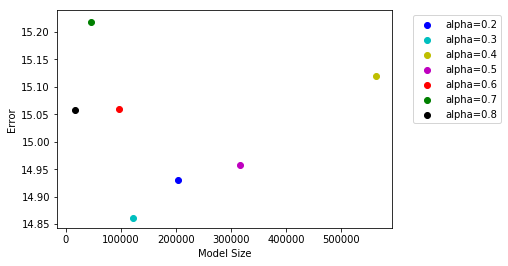

In [13]:
import numpy as np
import matplotlib.pyplot as plt

'''
mean_1 = 234
mean_2 = 227
mean_3 = 235
mean_4 = 285
mean_5 = 223
mean_6 = 275
mean_7 = 276
size = [17009, 46073, 123217, 204857, 316369, 498657, 564009]
error = [mean_1, mean_2, mean_3, mean_4, mean_5, mean_6, mean_7]
'''

np_sizes = np.array(model_sizes)
np_cv_errors = np.array(np.sqrt(cv_errors))
np_test_errors = np.array(np.sqrt(test_errors))
np_alphas = np.array(alphas)
colors = ['b', 'c', 'y', 'm', 'r', 'g', 'k']
n1 = plt.scatter(np_sizes[0], np_cv_errors[0], color = colors[0], label = 'alpha='+np_alphas[0])
n2 = plt.scatter(np_sizes[1], np_cv_errors[1], color = colors[1], label = 'alpha='+np_alphas[1])
n3 = plt.scatter(np_sizes[2], np_cv_errors[2], color = colors[2], label = 'alpha='+np_alphas[2])
n4 = plt.scatter(np_sizes[3], np_cv_errors[3], color = colors[3], label = 'alpha='+np_alphas[3])
n5 = plt.scatter(np_sizes[4], np_cv_errors[4], color = colors[4], label = 'alpha='+np_alphas[4])
n6 = plt.scatter(np_sizes[5], np_cv_errors[5], color = colors[5], label = 'alpha='+np_alphas[5])si 
n7 = plt.scatter(np_sizes[6], np_cv_errors[6], color = colors[6], label = 'alpha='+np_alphas[6])
plt.legend(bbox_to_anchor=(1.05, 1),loc=2)
plt.xlabel('Model Size')
plt.ylabel('Error')
plt.show()
